# Sentinel Hub OGC web services from within python

## Web Map Service (WMS) and Web Coverage Service (WCS)

This example notebook shows how to use WMS and WCS services provided by [Sentinel Hub](https://www.sentinel-hub.com/develop/documentation/api/ogc_api) to download Sentinel-2 imagery, i.e. in a form of unprocessed bands (_B01_, _B02_, ..., _B08_, _B8A_, ..., _B12_) or as processed products such as true color imagery, _NDVI_, etc. All imagery is returned as numpy arrays.

### Prerequisite: Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, create one at [Sentinel Hub webpage](https://www.sentinel-hub.com). 

Once you have the account set up, write down your **_instance id_** (alpha-numeric code of length 36) in the next cell.

In [1]:
INSTANCE_ID = ''

#### Imports 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import datetime

In [5]:
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType
from sentinelhub.common import BBox, CRS

In [6]:
def plot_image(data, factor=1):
    """
    Utility function for plotting RGB images. The numpy arrays returned by the WMS and WCS requests have channels
    ordered as Blue (`B02`), Green (`B03`), and Red (`B04`) therefore the order has to be reversed before ploting 
    the image.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    rgb = np.zeros(data.shape, dtype=np.float32)
    rgb[..., 0] = data[..., 2]
    rgb[..., 1] = data[..., 1]
    rgb[..., 2] = data[..., 0]
    plt.imshow(rgb*factor)

## Example: Betsiboka Estuary 

We will download Sentinel-2 imagery of [Betsiboka Estuary](https://en.wikipedia.org/wiki/Betsiboka_River) such as the one shown below (taken by Sentinel-2 on 2017-12-15):
![title](pics/wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-15T07-12-03_512X856.png)

The bounding box in _WGS84_ coordinate system is (latitude and longitude coordinates of upper left and lower right corners): 

In [7]:
betsiboka_coords_wgs84 = [-16.15, 46.16, -15.58, 46.51]

All requests require bounding box to be given as an instance of `sentinelhub.common.BBox` with corresponding Coordinate Reference System (`sentinelhub.common.CRS`). In our case it is in _WGS84_ and we can use the predefined _WGS84_ coordinate reference system from `sentinelhub.common.CRS`.

In [8]:
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, 
                      crs=CRS.WGS84)

### WMS request 

#### Example 1: True color (PNG) on a specific date

We need to specify the following arguments in the initialization of a `WmsRequest`:
 * `layer` - set it to `'TRUE_COLOR'`
    * Every Sentinel Hub account has a `TRUE_COLOR` layer by default (you can define new layers or edit existing ones in your account by using [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/#/)).
 * `bbox` - see above
 * `time` - Acquisition date 
     * we'll set it to 2017-12-15
 * `width` and `height` - width and height of a returned image
     * we'll set it to 512 and 856, respectively
 * `instance_id` - see above
 
All of the above arguments are obligatory and have to be set for all `WmsRequest`s.

In [9]:
wms_true_color_request = WmsRequest(layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox, 
                                    time='2017-12-15', 
                                    width=512, height=856,
                                    instance_id=INSTANCE_ID)

In [10]:
wms_true_color_img = wms_true_color_request.get_data()

In [11]:
print('Returned data is of type = %s and length %d.' % (type(wms_true_color_img), len(wms_true_color_img)))

Returned data is of type = <class 'list'> and length 1.


In [12]:
print('Single element in the list is of type = {} and has shape {}'.format(type(wms_true_color_img[-1]), wms_true_color_img[-1].shape))

Single element in the list is of type = <class 'numpy.ndarray'> and has shape (856, 512, 3)


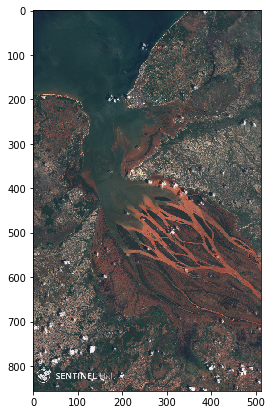

In [13]:
plot_image(wms_true_color_img[-1],1./255)

#### Example 2: True color of the latest acquisition

In order to get the latest Sentinel-2 acquisition set the `time` argument to `'latest'`.

In [14]:
wms_true_color_request = WmsRequest(layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox,
                                    time='latest',
                                    width=512, height=856, 
                                    instance_id=INSTANCE_ID)

In [15]:
wms_true_color_img = wms_true_color_request.get_data()

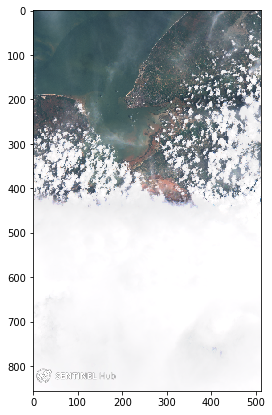

In [16]:
plot_image(wms_true_color_img[-1],1./255)

In [17]:
print('The latest Sentinel-2 image of this area was taken on {}.'.format(wms_true_color_request.get_dates()[-1]))

The latest Sentinel-2 image of this area was taken on 2018-01-09 07:12:07.


#### Example 3: True color of the multiple acquisitions in certain time window

In order to get all Sentinel-2 acquisitions taken in a certain time interval set the `time` argument to tuple with two elements (`start date`,`end date`).

In [18]:
wms_true_color_request = WmsRequest(layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox,
                                    time=('2017-12-01', '2017-12-31'),
                                    width=512, height=856,
                                    instance_id=INSTANCE_ID)

In [19]:
wms_true_color_img = wms_true_color_request.get_data()

In [20]:
print('There are %d Sentinel-2 images available for December 2017.' % len(wms_true_color_img))

There are 6 Sentinel-2 images available for December 2017.


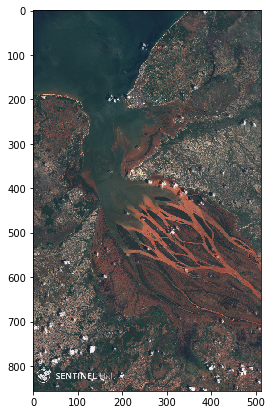

In [21]:
plot_image(wms_true_color_img[2], 1./255)

In [22]:
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 6 images were taken on the following dates:
 - image 0 was taken on 2017-12-05 07:13:30
 - image 1 was taken on 2017-12-10 07:12:10
 - image 2 was taken on 2017-12-15 07:12:03
 - image 3 was taken on 2017-12-20 07:12:10
 - image 4 was taken on 2017-12-25 07:12:04
 - image 5 was taken on 2017-12-30 07:12:09


#### Example 4: True color of the multiple acquisitions in certain time window with cloud coverage less than 30%

In order to get only Sentinel-2 acquisitions with cloud coverage less than certain amount set `maxcc` argument to that value. Note that this cloud coverage is estimated on the entire Sentinel-2 tile and not just for the region defined by our bounding box.

In [23]:
wms_true_color_request = WmsRequest(layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox,
                                    time=('2017-12-01', '2017-12-31'),
                                    width=512, height=856, 
                                    maxcc=0.3,
                                    instance_id=INSTANCE_ID)

In [24]:
wms_true_color_img = wms_true_color_request.get_data()

In [25]:
print('There are %d Sentinel-2 images available for December 2017 with cloud coverage less than %1.0f%%.' % (len(wms_true_color_img), wms_true_color_request.maxcc * 100.0))

There are 2 Sentinel-2 images available for December 2017 with cloud coverage less than 30%.


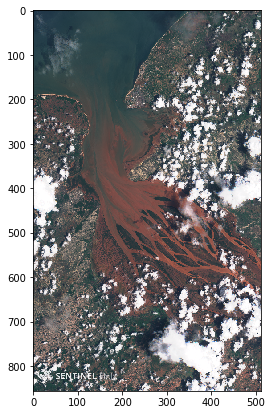

In [26]:
plot_image(wms_true_color_img[-1], 1./255)

In [27]:
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 2 images were taken on the following dates:
 - image 0 was taken on 2017-12-15 07:12:03
 - image 1 was taken on 2017-12-20 07:12:10


#### Example 5: All Sentinel-2's raw band values 

Everything is the same as in the case of *Example 1* except that we need to change the `layer` argument to `'ALL_BANDS'`, assuming that you have set `ALL_BANDS` layer in Sentinel Hub Configurator. In this case we also have to set the `image_format` argument to `sentinelhub.constants.MimeType.TIFF_d32f`, since we can't pack all Sentinel-2's 13 bands into a png. 

In [28]:
wms_bands_request = WmsRequest(layer='ALL_BANDS',
                               bbox=betsiboka_bbox, 
                               time='2017-12-15',
                               width=512, height=856,
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)

In [29]:
wms_bands_img = wms_bands_request.get_data()

In [30]:
wms_bands_img[-1].shape

(856, 512, 13)

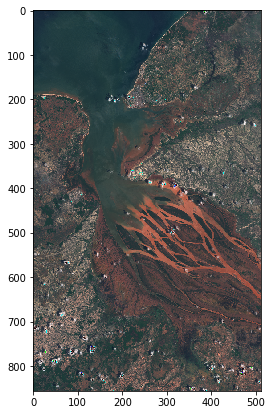

In [31]:
plot_image(wms_bands_img[-1][:, :, 1:4], 2.5)

#### Example 6: Save downloaded data to disk and read it from disk

All downloaded data can be saved to disk and later on read from it. Simply specify the location on disk where data should be saved (or loaded from) via `data_folder` argument of request's constructor and set the argument `save_data` of `get_data` method to `True`.

In [32]:
wms_bands_request = WmsRequest(data_folder='test_dir',
                               layer='ALL_BANDS',
                               bbox=betsiboka_bbox, 
                               time='2017-12-15', 
                               width=512, height=856,
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)

In [33]:
%%time
wms_bands_img = wms_bands_request.get_data(save_data=True)

CPU times: user 137 ms, sys: 13.5 ms, total: 150 ms
Wall time: 150 ms


The output directory has been created and tiff file with all 13 bands was saved.

In [34]:
!ls {wms_bands_request.data_folder}

wms_ALL_BANDS_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-15T07-12-03_512X856_tiff_depth32f.tiff


Since data has been already downloaded the next request will read the data from disk instead of downloading it.

In [35]:
wms_bands_request_from_disk = WmsRequest(data_folder='test_dir',
                                         layer='ALL_BANDS',
                                         bbox=betsiboka_bbox, 
                                         time='2017-12-15', 
                                         width=512, height=856,
                                         image_format=MimeType.TIFF_d32f,
                                         instance_id=INSTANCE_ID)

In [36]:
%%time
wms_bands_img_from_disk = wms_bands_request_from_disk.get_data()

CPU times: user 131 ms, sys: 10.2 ms, total: 141 ms
Wall time: 141 ms


In [37]:
if np.array_equal(wms_bands_img[-1], wms_bands_img_from_disk[-1]):
    print('Arrays are equal.')
else:
    print('Arrays are different.')

Arrays are equal.


If you need to redownload the data again, just set the `redownload` argument of `get_data()` method to `True`. 

In [38]:
%%time
wms_bands_img_redownload = wms_bands_request_from_disk.get_data(redownload=True)

CPU times: user 319 ms, sys: 106 ms, total: 425 ms
Wall time: 14.9 s


#### Example 7: Save downloaded data directly to disk

The `get_data` method returns a list of numpy arrays and can save the downloaded data to disk, as we have seen in the previous example. Sometimes you would just like to save the data directly to disk for later use. You can do that by using `save_data` method instead.

In [39]:
wms_true_color_request = WmsRequest(data_folder='test_dir_png',
                                    layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox, 
                                    time=('2017-12-01','2017-12-31'), 
                                    width=512, height=856,
                                    image_format=MimeType.PNG,
                                    instance_id=INSTANCE_ID)

In [40]:
%%time
wms_bands_img = wms_true_color_request.save_data()

CPU times: user 1.2 ms, sys: 4.6 ms, total: 5.81 ms
Wall time: 3.6 ms


The output directory has been created and png files for all 6 images should be in it.

In [41]:
!ls {wms_true_color_request.data_folder}

wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-05T07-13-30_512X856.png
wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-10T07-12-10_512X856.png
wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-15T07-12-03_512X856.png
wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-20T07-12-10_512X856.png
wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-25T07-12-04_512X856.png
wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-30T07-12-09_512X856.png


#### Example 8: Merging two or more download requests into one

If the bounding box is too large so that it spans over two or more Sentinel-2 tiles and each of them has different time stamp, then two or more download requests will be created resulting in two or more downloaded images which can be blank sometimes. This can happen for example for tiles from the same orbit but from two different data strips.

Let's look at the specific example. Again, we're going to look at Betsiboka estuary, but we'll increase the bounding box so that we cover an area from two different Senteinel-2 tiles.

In [42]:
betsiboka_bbox_large = BBox(bbox=[-16.12, 45.88,-15.45, 47.29], 
                            crs=CRS.WGS84)

wms_true_color_request = WmsRequest(layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox_large, 
                                    time='2015-12-01', 
                                    width=480, height=270,
                                    image_format=MimeType.PNG,
                                    instance_id=INSTANCE_ID)

wms_true_color_img = wms_true_color_request.get_data()

In [43]:
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 2 images were taken on the following dates:
 - image 0 was taken on 2015-12-01 07:12:50
 - image 1 was taken on 2015-12-01 07:17:21


As you can see, the images are from the same day, their time stamp differs only for about 5 minutes. Clearly these can't come from different acquisitions of Sentinel-2 satellite(s). Let's take a look.

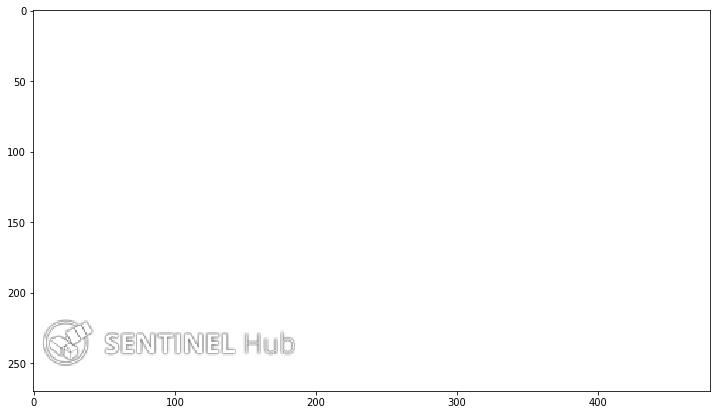

In [44]:
plot_image(wms_true_color_img[0], 1./255)

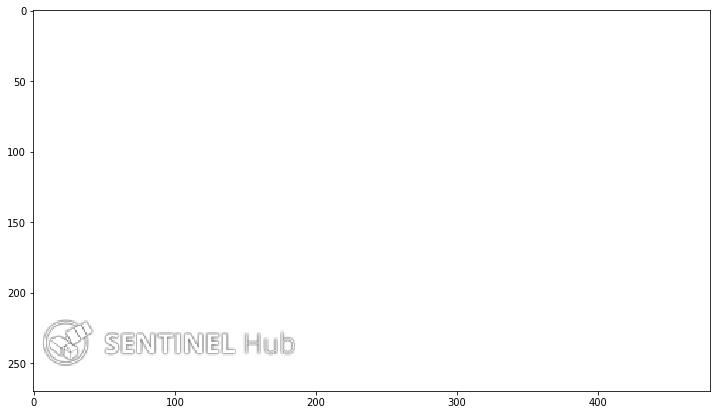

In [45]:
plot_image(wms_true_color_img[1], 1./255)

If we increase the image size, we'll actually get non-blank images, but same.

In [46]:
betsiboka_bbox_large = BBox(bbox=[-16.12, 45.88,-15.45, 47.29], 
                            crs=CRS.WGS84)

wms_true_color_request = WmsRequest(layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox_large, 
                                    time='2015-12-01', 
                                    width=960, height=540,
                                    image_format=MimeType.PNG,
                                    instance_id=INSTANCE_ID)

wms_true_color_img = wms_true_color_request.get_data()

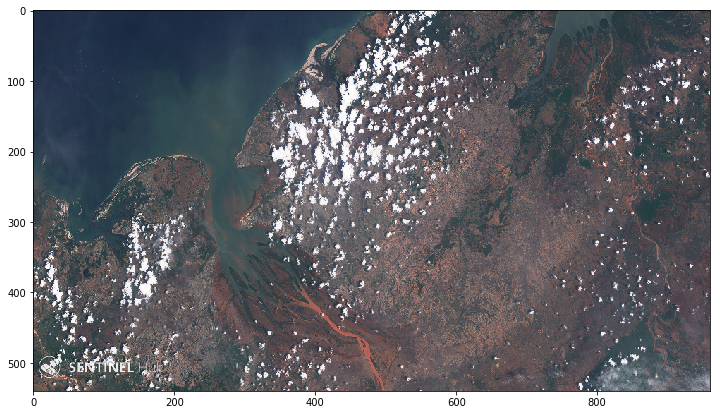

In [47]:
plot_image(wms_true_color_img[0], 1./255)

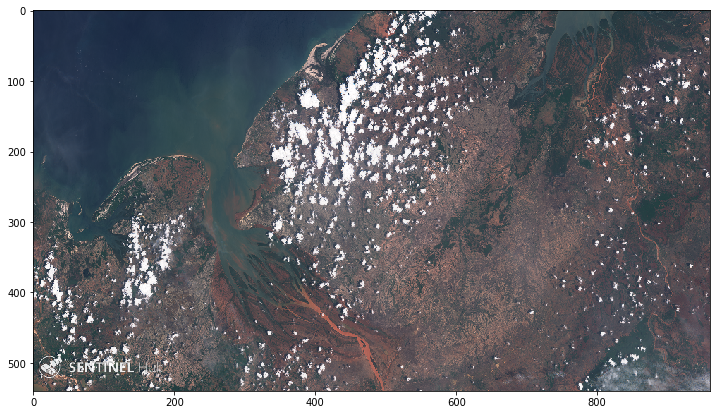

In [48]:
plot_image(wms_true_color_img[1], 1./255)

Clearly these are the same images and we usually would want to get only one. We can do that by widening the time interval in which two or more download requests are considered to be the same. In our example it is enough to widen the time window for 10 minutes, but usually it can be up to two hours. This is done by setting the `time_difference` argument.

In [49]:
betsiboka_bbox_large = BBox(bbox=[-16.12, 45.88,-15.45, 47.29], 
                            crs=CRS.WGS84)

wms_true_color_request_with_deltat = WmsRequest(layer='TRUE_COLOR',
                                                bbox=betsiboka_bbox_large, 
                                                time='2015-12-01', 
                                                width=960, height=540,
                                                image_format=MimeType.PNG,
                                                instance_id=INSTANCE_ID,
                                                time_difference=datetime.timedelta(hours=2))

wms_true_color_img = wms_true_color_request_with_deltat.get_data()

In [50]:
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request_with_deltat.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 1 images were taken on the following dates:
 - image 0 was taken on 2015-12-01 07:12:50


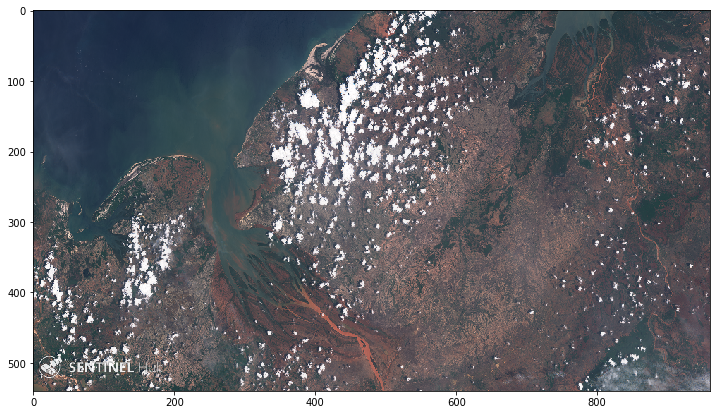

In [51]:
plot_image(wms_true_color_img[-1], 1./255)

Even the problem with blank image goes away.

In [56]:
betsiboka_bbox_large = BBox(bbox=[-16.12, 45.88, -15.45, 47.29], 
                            crs=CRS.WGS84)

wms_true_color_request = WmsRequest(layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox_large, 
                                    time='2015-12-01', 
                                    width=480, height=270,
                                    image_format=MimeType.PNG,
                                    instance_id=INSTANCE_ID,
                                    time_difference=datetime.timedelta(hours=2))

wms_true_color_img = wms_true_color_request.get_data()

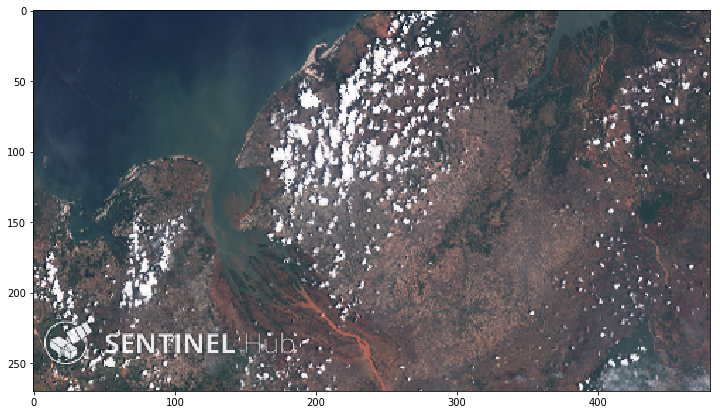

In [57]:
plot_image(wms_true_color_img[-1], 1./255)

### WCS request

The use of `WcsRequest` is exactly the same as of the `WmsRequest` shown above. The only difference is that instead of requesting an image of fixed (but variable pixel resolution) size like in the latter case we require an image with  the fixed pixel resolution (but variable image size) in the former case. We specify the resolution by setting the `resx` and `resy` arguments to the desired resolution in meters (i.e. to `'10m'` for the resolution of 10 meters).

#### Example 9: True color (PNG) on a specific date 

In [52]:
wcs_true_color_request = WcsRequest(layer='TRUE_COLOR',
                                    bbox=betsiboka_bbox, 
                                    time='2017-12-15', 
                                    resx='20m', resy='20m',
                                    instance_id=INSTANCE_ID)

In [53]:
wcs_true_color_img = wcs_true_color_request.get_data()

In [54]:
print('Single element in the list is of type = {} and has shape {}'.format(type(wcs_true_color_img[-1]), wcs_true_color_img[-1].shape))

Single element in the list is of type = <class 'numpy.ndarray'> and has shape (3170, 1872, 3)


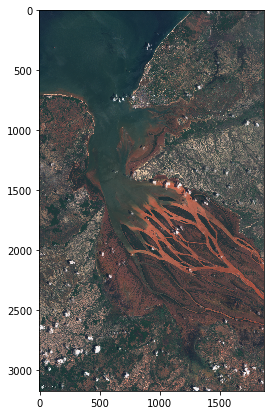

In [55]:
plot_image(wcs_true_color_img[-1], 1./255)